# Read images

In [10]:
# Import library
from skimage.io import imread
from skimage.transform import resize
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
folders = ['person-1', 'person-2', 'person-3', 'person-4', 'person-5',
           'person-6', 'person-7', 'person-8', 'person-9', 'person-10',
           'person-11', 'person-12', 'person-13', 'person-14', 'person-15']

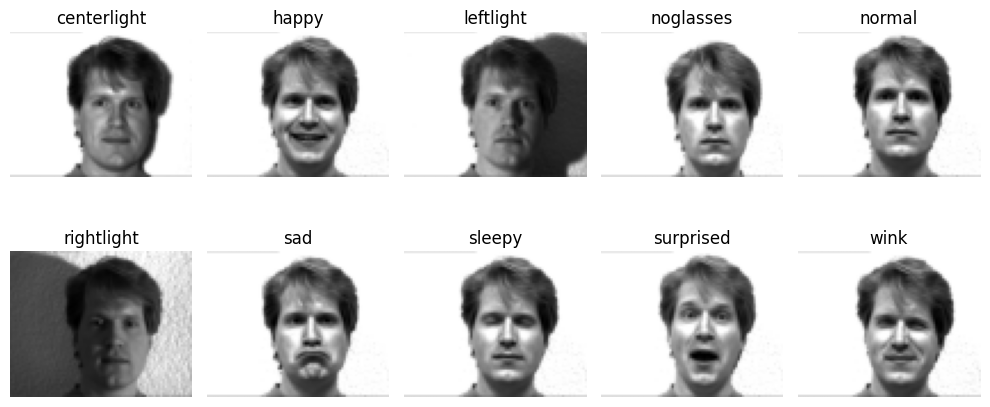

In [6]:
person_folder = random.choice(folders)
plt.figure(figsize=(10, 5))
for i, file in enumerate(os.listdir(os.path.join("/content/drive/MyDrive/colab_files/yalefaces", person_folder))):
    image = imread(os.path.join("/content/drive/MyDrive/colab_files/yalefaces", person_folder, file))
    image = image.squeeze(0)
    image = resize(image, (64, 80), anti_aliasing=True)
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(file)

plt.tight_layout()
plt.show()

In [12]:
data = {}
for folder in folders:
    for file in os.listdir(os.path.join("/content/drive/MyDrive/colab_files/yalefaces", folder)):
        image = imread(os.path.join("/content/drive/MyDrive/colab_files/yalefaces", folder, file))
        image = resize(image, (1, 64, 80), anti_aliasing=True)
        if folder not in data:
            data[folder] = [image]
        else:
            data[folder].append(image)

for person in data:
    data[person] = np.concatenate(data[person], axis=0).reshape(10, -1)

In [13]:
data['person-1'].shape

(10, 5120)

# Standardize image

In [14]:
def standardize(images):
    images = (images - images.mean()) / images.std()
    images = images.astype(np.float32)
    return images

# PCA

In [15]:
class PrincipalComponentAnalysis:
    def __init__(self, d_principle):
        self.d_principle = d_principle

    def fit(self, X):
        cov = (X.T @ X)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # change the sign maximum to positive
        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
        eigenvectors = eigenvectors * signs[np.newaxis, :]
        eigenvectors = eigenvectors.T

        # rearrange
        eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i, :]) for i in range(eigenvectors.shape[0])]

        # sort tuples
        eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)

        # convert to ndarray
        eigenvalues = np.array([value for (value, _) in eigen_pairs])
        eigenvectors = np.array([value for (_, value) in eigen_pairs])

        # select principle component
        self.principle_components = eigenvalues[:self.d_principle]
        self._W = eigenvectors[:self.d_principle]

    def transform(self, X):
        y_hat = self._W @ X
        return y_hat

# Find principle component

In [16]:
pca = PrincipalComponentAnalysis(d_principle=20)

In [17]:
images = []
for person in data:
    images.append(data[person])
images = np.concatenate(images, axis=0)
images = standardize(images)
images.shape

(150, 5120)

In [18]:
pca.fit(images)

In [19]:
pca._W.shape

(20, 5120)

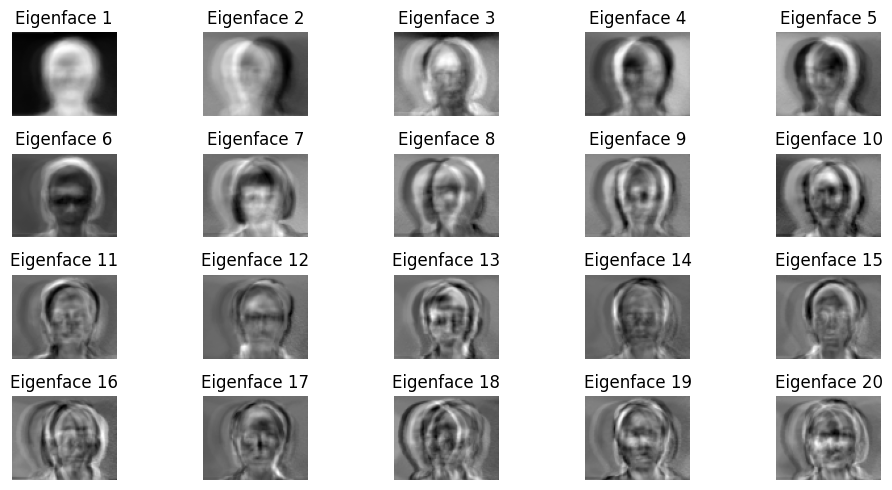

In [20]:
eigen_faces = pca._W
eigen_faces = eigen_faces.reshape(20, 64, 80)
plt.figure(figsize=(10, 5))
for i, eigen_face in enumerate(eigen_faces):
    plt.subplot(4, 5, i+1)
    plt.imshow(eigen_face, cmap='gray')
    plt.axis('off')
    plt.title(f'Eigenface {i+1}')

plt.tight_layout()
plt.show()

# Find mean face

In [21]:
mean_faces = {person: np.mean(images, axis=0) for person, images in data.items()}

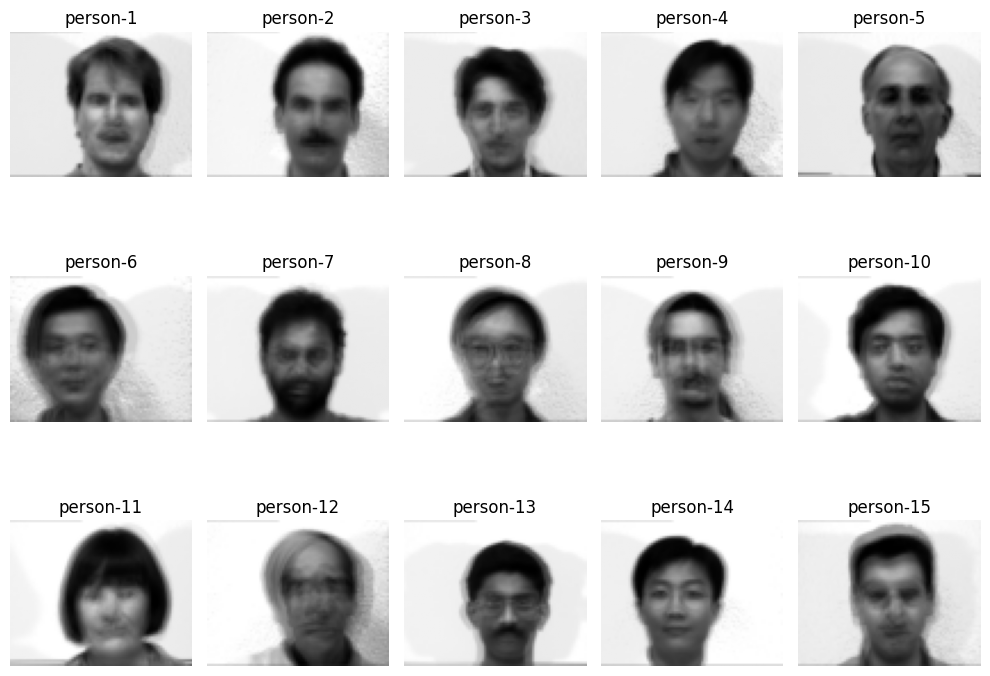

In [22]:
plt.figure(figsize=(10, 8))
for i, person in enumerate(mean_faces):
    mean_face = mean_faces[person]
    mean_face = mean_face.reshape(64, 80)
    plt.subplot(3, 5, i+1)
    plt.imshow(mean_face, cmap='gray')
    plt.axis('off')
    plt.title(person)

plt.tight_layout()
plt.show()

# Project mean faces into Principle space

In [23]:
projected_mean_faces = {}
for person in mean_faces:
    projected_mean_faces[person] = pca.transform(mean_faces[person])

# Load dataset

In [24]:
labels = []
test_images = []
for file in os.listdir("/content/drive/MyDrive/colab_files/yalefaces/test"):
    person_name = file.split('.')[0]
    labels.append(person_name)
    image = imread(os.path.join("/content/drive/MyDrive/colab_files/yalefaces/test", file))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    test_images.append(image)

In [25]:
test_images = np.concatenate(test_images, axis=0)
test_images.shape

(15, 64, 80)

In [26]:
labels

['person-1',
 'person-2',
 'person-3',
 'person-5',
 'person-6',
 'person-7',
 'person-8',
 'person-9',
 'person-10',
 'person-11',
 'person-12',
 'person-13',
 'person-14',
 'person-15',
 'person-4']

# Test model

In [27]:
def euclid_dis(X, Y):
    assert X.shape == Y.shape, f"{X.__str__()} and {Y.__str__()} are miss-shaped"
    return (((X - Y)**2).sum())**0.5

In [30]:
predicts = {}
for label, image in zip(labels, test_images):
    image = image.reshape(-1)
    projected_face = pca.transform(image)
    close_dis = np.inf
    close_person = None
    for person in projected_mean_faces:
        mean_face = projected_mean_faces[person]
        dis = euclid_dis(mean_face, projected_face)
        if dis < close_dis:
            close_dis = dis
            close_person = person
    predicts[label] = close_person

In [32]:
EMs = []
for label in predicts:
    EMs.append(label == predicts[label])
print(f'Accuracy: {np.mean(EMs)*100:0.2f}')

Accuracy: 66.67
